# Preparing an input peptide with CHUCKLES representation
This Jupyter notebook demonstrates how to prepare a peptide into a CHUCKLES representations to query the PepINVENT model.\
The RDKit, RDChiral and OpenBabel packages are required to run this notebook.

In [1]:
from rdkit import RDLogger
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import rdDepictor
from openbabel import openbabel
from openbabel import pybel
from collections import Counter
from typing import List
import re
RDLogger.DisableLog('rdApp.*')

# Load your amino acid library
This requires a database of the amino acid names and their SMILES.

In [3]:
amino_acids = pd.read_csv('./amino_acid_options.csv')
amino_acids

,Smiles,Name
0,N=C(N)NCCC[C@H](N)C(=O)O,R
1,N[C@@H](Cc1c[nH]cn1)C(=O)O,H
2,NCCCC[C@H](N)C(=O)O,K
3,N[C@@H](CC(=O)O)C(=O)O,D
4,N[C@@H](CCC(=O)O)C(=O)O,E
5,N[C@@H](CO)C(=O)O,S
6,C[C@@H](O)[C@H](N)C(=O)O,T
7,NC(=O)C[C@H](N)C(=O)O,N
8,NC(=O)CC[C@H](N)C(=O)O,Q
9,N[C@@H](CS)C(=O)O,C


You can make a substructure search to find which amino acids can be slotted in for sidechains or disulfude bridge cyclizations.

In [4]:
molecules = [Chem.MolFromSmiles(smi) for smi in list(amino_acids['Smiles'])]

smarts_patterns = {'Sidechains containing carboxylic acid': '[O;$([O;D1]C(=O)[A]);!$(OC(=O)C[ND1,ND2]):55]',
          'Sidechains containing amine group': '[ND1;!+;!$(NCc);$(N[C]);!$(N*=*);!$(NCC(=O)O):55]',
          'Sidechains containing sulfhydryl group': '[S;D1,D2;!$(S(=O));!$(S(=[C,c]));!$(S([C,c])[C,c])]',
         }

for name, smarts in smarts_patterns.items():
    sub = Chem.MolFromSmarts(smarts)

    filtered_molecules = [mol for mol in molecules if mol.HasSubstructMatch(sub)]
    pep_id = [idx for idx, mol in zip(list(amino_acids['Name']), molecules) if mol.HasSubstructMatch(sub)]
    print(name)
    print(pep_id)
    print()
    highlights = [[a[0] for a in m.GetSubstructMatches(sub)] for m in filtered_molecules]

Sidechains containing carboxylic acid
['D', 'E']

Sidechains containing amine group
['K']

Sidechains containing sulfhydryl group
['C', 'WXI', 'ZN9', 'M6E']


# Functions for CHUCKLES representation
CHUCKLES was adapted from Cyclops*.
The CHUCKLES pattern provided here is intended to be applied on alpha-amino acids. 

*CycloPs: generating virtual libraries of cyclized and constrained peptides including nonnatural amino acids FJ Duffy, M Verniere, M Devocelle, E Bernard, DC Shields, AJ Chubb Journal of chemical information and modeling 51 (4), 829-836
https://github.com/fergaljd/cyclops

In [5]:
def convert_to_chuckles(aa_smiles):
    mol = pybel.readstring('smi', aa_smiles)
    try:
        n_term_pat = pybel.Smarts('[$([ND1,ND2]CC(O)=O)]')
        c_term_pat = pybel.Smarts('[$([OD1]C(=O)C[ND1,ND2])]')
        n_term_idx = n_term_pat.findall(mol)[0][0]
        c_term_idx = c_term_pat.findall(mol)[0][0]
    except:
        print('Cannot produce CHUCKLES from', aa_smiles)

    rearranger = openbabel.OBConversion()
    rearranger.SetInAndOutFormats('smi', 'smi')
    rearranger.AddOption('f', openbabel.OBConversion.OUTOPTIONS, str(n_term_idx))
    rearranger.AddOption('l', openbabel.OBConversion.OUTOPTIONS, str(c_term_idx))
    outmol = openbabel.OBMol()
    rearranger.ReadString(outmol, aa_smiles)
    return rearranger.WriteString(outmol).strip()

def uncharger(smiles):
    mol = Chem.MolFromSmiles(smiles)
    uncharger = rdMolStandardize.Uncharger() 
    if mol:
        uncharged_mol = uncharger.uncharge(mol)
        uncharged_smi = Chem.MolToSmiles(uncharged_mol, isomericSmiles=True)
    else:
        uncharged_smi = None
    return uncharged_smi

def remove_backbone_charges(original_smiles):
    if '[O-]' in original_smiles:
        modified_smiles = re.sub(r'\[O\-\]', 'O', original_smiles)
    else:
        modified_smiles = original_smiles
    return modified_smiles

def smiles_to_chuckles(amino_acid):
    # Preprocessing
    uncharged_aa = uncharger(amino_acid) 
    uncharged_aa = remove_backbone_charges(uncharged_aa) 

    # Convert to CHUCKLES
    chuckles_aa = convert_to_chuckles(uncharged_aa)
    return chuckles_aa

def peptide2chuckles(amino_acids):
    aas = [smiles_to_chuckles(aa) for aa in amino_acids]
    return aas

# Functions constructing the peptide topology

In [6]:
def cycle_mapping(smiles):
    map_num = 0
    numbers = []
    for s in smiles:
        num = [int(x) for x in [*s] if x.isdigit()]
        numbers.extend(num)
    if len(numbers)>1:
        map_num = max(numbers)
    return map_num + 1   

def linear(smiles):
    smiles[-1] = smiles[-1] +'O'
    return smiles

def head_to_tail(smiles):
    mapping_num = cycle_mapping(smiles)
    
    start_pos, end_pos = 0, -1
    cycle_start = smiles[start_pos]
    smiles[start_pos] = cycle_start[0] + f'{mapping_num}' + cycle_start[1:]
    
    cycle_end = smiles[end_pos]
    smiles[end_pos] = cycle_end[:-5] + f'{mapping_num}' + cycle_end[-5:]
    return smiles

def smarts_pattern_match(smi, smarts):
    substructure = Chem.MolFromSmarts(smarts)
    mol = Chem.MolFromSmiles(smi)
    smarts_match = mol.HasSubstructMatch(substructure)
    return smarts_match  

def disulfide_bridge(smiles, cyclization_info):
    mapping_num = cycle_mapping(smiles)
    
    for pos in cyclization_info:
        sulfhdryl_smarts = '[S;D1,D2;!$(S(=O));!$(S(=[C,c]));!$(S([C,c])[C,c])]'
        smarts_match = smarts_pattern_match(smiles[pos], sulfhdryl_smarts) 
        if not smarts_match:
            raise ValueError(f'The chosen amino acid at position {pos} does not have a sulfhydryl (-SH) group.')
            
    start_pos, end_pos = cyclization_info[0], cyclization_info[1] 
    
    cycle_start = smiles[start_pos]
    smiles[start_pos] = re.sub(r'(S)', fr'S{mapping_num}', cycle_start)

    cycle_end = smiles[end_pos]
    smiles[end_pos] = re.sub(r'(S)', fr'S{mapping_num}', cycle_end)
    smiles[-1] = smiles[-1] +'O'
    return smiles


def sidechain_to_tail(smiles, cyclization_info):
    mapping_num = cycle_mapping(smiles)
            
    start_pos, end_pos = cyclization_info[0], cyclization_info[1] 

    cycle_start = smiles[start_pos]
    cycle_starting_smi = prepare_sidechain(cycle_start, 'Sidechain-To-Tail')
    if not cycle_starting_smi:
        raise ValueError(f'The chosen amino acid at position {start_pos} does not have a amino group.')
    
    cycle_starting_smi = cycle_starting_smi.replace("[U]", str(mapping_num))
    smiles[start_pos] = cycle_starting_smi
    
    cycle_end = smiles[end_pos]
    smiles[end_pos] = cycle_end[:-5] + str(mapping_num) + cycle_end[-5:]
    return smiles 


def head_to_sidechain(smiles, cyclization_info):
    mapping_num = cycle_mapping(smiles)
            
    start_pos, end_pos = cyclization_info[0], cyclization_info[1] 

    cycle_end = smiles[end_pos]
    cycle_ending_smi = prepare_sidechain(cycle_end, 'Head-To-Sidechain')
    if not cycle_ending_smi:
        raise ValueError(f'The chosen amino acid at position {end_pos} does not have a carboxylic acid group.')
    
    cycle_ending_smi = cycle_ending_smi.replace("[U]", str(mapping_num))
    smiles[end_pos] = cycle_ending_smi
    
    cycle_start = smiles[start_pos]
    smiles[start_pos] = cycle_start[0] + f'{mapping_num}' + cycle_start[1:]
    smiles[-1] = smiles[-1] +'O'
    return smiles

    
def mutate_sidechain(smi, topology):
    ''' Temporarily replaces cyclization point to [U] '''
    if topology == 'Sidechain-To-Tail':
        # Smarts for the amine group 
        sidechain_group_smarts = '[ND1;!+;!$(NCc);$(N[C]);!$(N*=*);!$(NCC(=O)O):55]'
        rxnSmarts = f'{sidechain_group_smarts}.[*:99]>>[*:55][*:99]'
        
    if topology == 'Head-To-Sidechain':
        # Smarts for the carboxylic group 
        sidechain_group_smarts = '[O;$([O;D1]C(=O)[A]);!$(OC(=O)C[ND1,ND2]):55]'
        rxnSmarts = f'{sidechain_group_smarts}.[*:99]>>[*:55][*:99]'
    
    smarts_match = smarts_pattern_match(smi, sidechain_group_smarts) 
    if not smarts_match:
        return None
    else:       
        mutated_aa = mutation_rxn(smi, rxnSmarts)
    return mutated_aa
        
def mutation_rxn(smi, rxnSmarts):  
    mol = Chem.MolFromSmiles(smi)
    rxn = AllChem.ReactionFromSmarts(rxnSmarts)
    reacts = (mol,  Chem.MolFromSmiles('[U]'))
    products = rxn.RunReactants(reacts)
    return Chem.MolToSmiles(products[0][0])

def prepare_sidechain(smi, topology):
    mutated_smi = mutate_sidechain(smi, topology)
    mutated_smi = convert_to_chuckles(mutated_smi)
    return mutated_smi


# Functions on building the peptide

In [7]:
def assign_topology(peptide_chuckles, topology, cyclization_info=None):
    '''Converts list of amino acid smiles into amino acids chuckles with the desired topological information
    
        peptide_chuckles: 
                A list of amino acids ordered according to their position in the intended peptide chain
        
        topology: 
                The choice of topology from the selection 
                [ Linear, Head-To-Tail, Sidechain-To-Tail, Head-To-Sidechain, Disulfide-Bridge ]
        
        cyclization_info: 
                A list of the positions of the chosen amino acids participating in the peptide cyclization. 
                Is only necessary for Sidechain-To-Tail, Head-To-Sidechain, Disulfide-Bridge
                '''
    if topology == 'Linear':
        peptide_with_topology = linear(peptide_chuckles)
        
    elif topology == 'Head-To-Tail':
        peptide_with_topology = head_to_tail(peptide_chuckles)
        
    elif topology == 'Sidechain-To-Tail':
        if cyclization_info:
            peptide_with_topology = sidechain_to_tail(peptide_chuckles, cyclization_info)
        else:
            raise ValueError("The positions of the amino acids in the cyclization has to be specified.")
        
    elif topology == 'Head-To-Sidechain':
        if cyclization_info:
            peptide_with_topology = head_to_sidechain(peptide_chuckles, cyclization_info)
        else:
            raise ValueError("The positions of the amino acids in the cyclization has to be specified.")
        
    elif topology == 'Disulfide-Bridge':
        if cyclization_info:
            peptide_with_topology = disulfide_bridge(peptide_chuckles, cyclization_info)
        else:
            raise ValueError("The positions of the amino acids in the cyclization has to be specified.")
        
    else:
        raise ValueError("This topology is not one of the available topologies: \n\t1) Linear\n\t2) Head-To-Tail\n\t3) Sidechain-To-Tail\n\t4) Head-To-Sidechain\n\t5) Disulfide-Bridge")

    return peptide_with_topology


def mask_peptide(peptide_chuckles, positions):
    peptide = peptide_chuckles.copy()
    masked_aas = ["?" if idx in positions else x for idx, x in enumerate(peptide)]
    return masked_aas

def merge_peptide(peptide_chuckles):
    peptide = [x[:-1] if x!="?" else x for x in peptide_chuckles]
    peptide = "|".join(peptide)
    return peptide

def merge_original_peptide(peptide_chuckles):
    peptide = [x[:-1] for x in peptide_chuckles]
    peptide = "".join(peptide)
    return peptide

def build_peptide(amino_acids: List, topology: str, masking_positions: List, cyclization_info=None):
    ''' Builds the peptide from a list of amino acids'''
    aa_chuckles = peptide2chuckles(amino_acids) 
    peptide_chuckles = assign_topology(aa_chuckles, topology, cyclization_info)
    masked_chuckles = mask_peptide(peptide_chuckles, masking_positions)
    
    input_peptide = merge_peptide(masked_chuckles)
    original_peptide = merge_original_peptide(peptide_chuckles)
    
    return original_peptide, input_peptide

def remove_invalid_info(smiles):
    cyclic_info = [int(x) for x in [*smiles] if x.isdigit()]
    cyclic_info = Counter(cyclic_info)
    cyclic_info = [k for k, v in cyclic_info.items() if v % 2 != 0]
    if len(cyclic_info) != 0:
        for cyclic_num in cyclic_info:
            smiles = smiles.replace(f"{cyclic_num}", "[*]")
    return smiles

def prepare_visualization(query, pepinvent_input, topology):
    print(f'Query Peptide:\n{query}\n\n')
    print(f'PepINVENT Input:\n{pepinvent_input}\n\n')
    new_input = pepinvent_input.replace("|", "")
    new_input = new_input.replace("?", "[U]")
    new_input = remove_invalid_info(new_input)
    smiles = [query, new_input]
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    
    tmp_substr = '[U]'
    substructures = [tmp_substr]*len(smiles)
    highlights = [[a for a in mol.GetSubstructMatches(Chem.MolFromSmarts(substructure))] for mol, substructure in zip(mols, substructures)]
    highlights = [sum(x, ()) if len(x)>=1 else None for x in highlights]
    
    # If set to false, the cyclic molecules look like a cycle
    # When True, linear molecules look straight
    if topology == 'Linear':
        rdDepictor.SetPreferCoordGen(True)
    else:
        rdDepictor.SetPreferCoordGen(False)
    opts = Draw.MolDrawOptions()
    opts.legendFraction = 0.25
    opts.legendFontSize = 40
    opts.highlightRadius = .5
    opts.setHighlightColour((0,.9,.9,.8))
    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(500,500), legends=['Query Peptide', 'PepINVENT Input'], drawOptions=opts, highlightAtomLists=highlights) 
    return img


# Examples
**1) Linear**\
**2) Head-To-Tail**  
**3) Sidechain-To-Tail**\
**4) Head-To-Sidechain**\
**5) Disulfide-Bridge**

Query Peptide:
N[C@@H](CS)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CS)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H](CS)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N1[C@@H](CCC1)C(=O)O


PepINVENT Input:
N[C@@H](CS)C(=O)|N[C@@H](Cc1ccc(O)cc1)C(=O)|N[C@@H](CS)C(=O)|?|N[C@@H]([C@H](CC)C)C(=O)|?|?|N[C@@H](CCC(=O)O)C(=O)|N1[C@@H](CCC1)C(=O)O


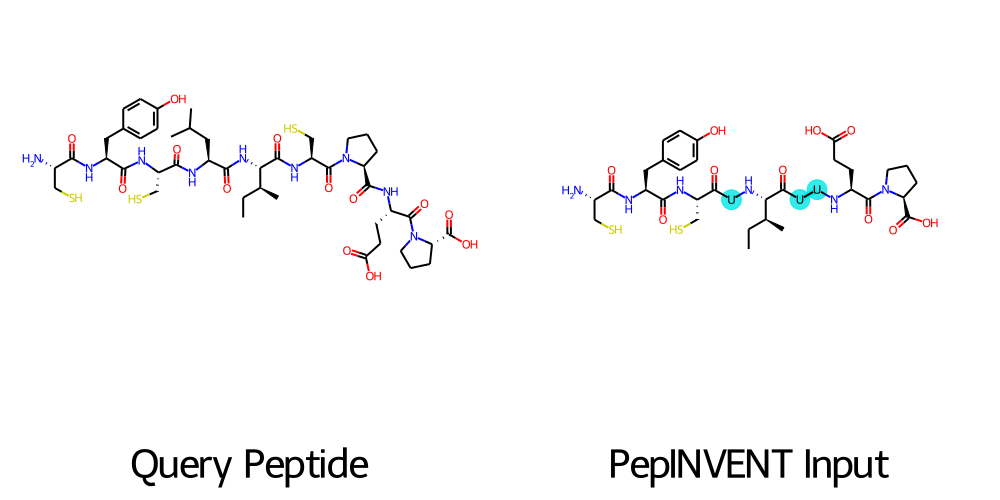

In [8]:
peptide_sequence = ['C', 'Y', 'C', 'L', 'I', 'C', 'P', 'E', 'P']
peptide_topology = 'Linear'
masking_positions = [3,5,6]

peptide_smiles = [amino_acids[amino_acids['Name']==seq]['Smiles'].values[0] for seq in peptide_sequence]

query_peptide, pepinvent_input = build_peptide(peptide_smiles, peptide_topology, masking_positions)
prepare_visualization(query_peptide, pepinvent_input, peptide_topology)

Query Peptide:
N2[C@@H](CS)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CS)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H](CS)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N1[C@@H](CCC1)C2(=O)


PepINVENT Input:
?|N[C@@H](Cc1ccc(O)cc1)C(=O)|?|?|N[C@@H]([C@H](CC)C)C(=O)|N[C@@H](CS)C(=O)|N1[C@@H](CCC1)C(=O)|N[C@@H](CCC(=O)O)C(=O)|N1[C@@H](CCC1)C2(=O)


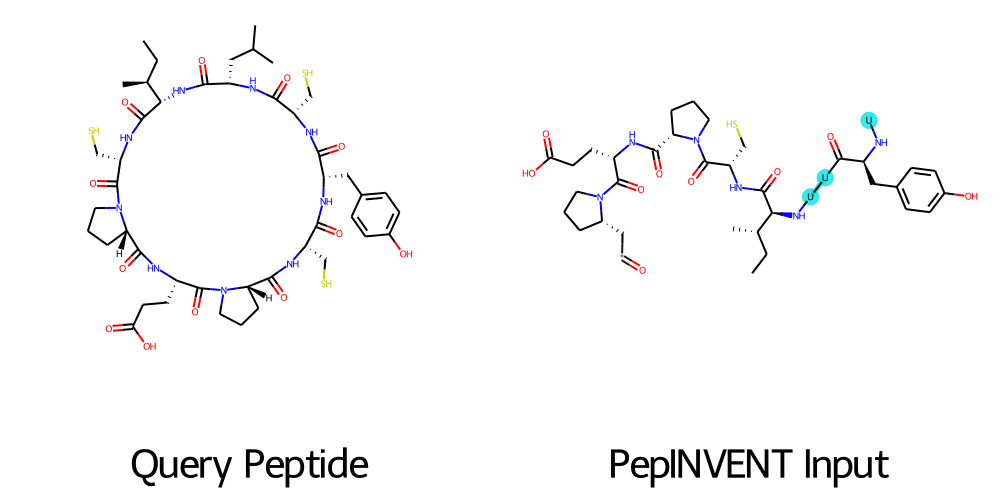

In [9]:
peptide_sequence = ['C', 'Y', 'C', 'L', 'I', 'C', 'P', 'E', 'P']
peptide_topology = 'Head-To-Tail'
masking_positions = [0,3,2]

peptide_smiles = [amino_acids[amino_acids['Name']==seq]['Smiles'].values[0] for seq in peptide_sequence]

query_peptide, pepinvent_input = build_peptide(peptide_smiles, peptide_topology, masking_positions)
prepare_visualization(query_peptide, pepinvent_input, peptide_topology)

Query Peptide:
N[C@@H](CS)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCCN2)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H](CS)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N1[C@@H](CCC1)C2(=O)


PepINVENT Input:
N[C@@H](CS)C(=O)|N[C@@H](Cc1ccc(O)cc1)C(=O)|N[C@@H](CCCCN2)C(=O)|?|N[C@@H]([C@H](CC)C)C(=O)|?|?|N[C@@H](CCC(=O)O)C(=O)|N1[C@@H](CCC1)C2(=O)


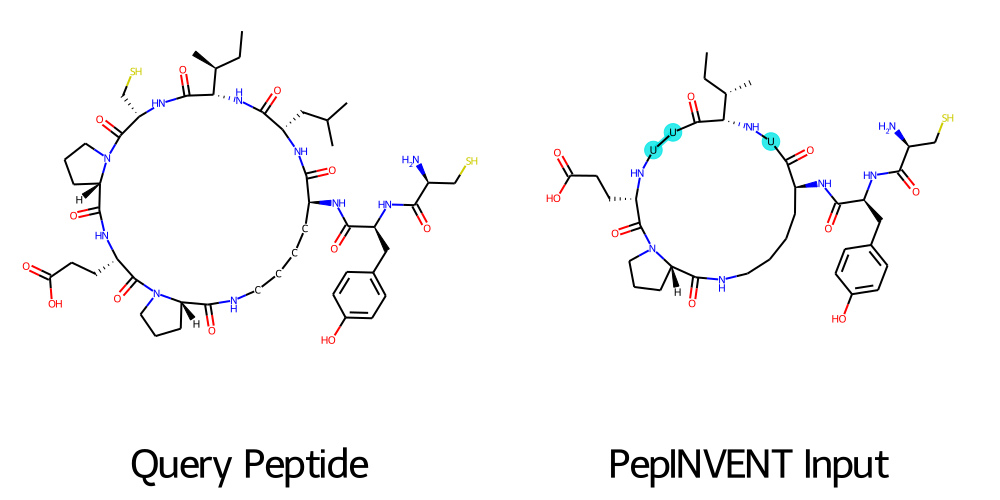

In [10]:
peptide_sequence = ['C', 'Y', 'K', 'L', 'I', 'C', 'P', 'E', 'P']
peptide_topology = 'Sidechain-To-Tail'
masking_positions = [3,5,6]
cyclization_info = [2, 8]

peptide_smiles = [amino_acids[amino_acids['Name']==seq]['Smiles'].values[0] for seq in peptide_sequence]

query_peptide, pepinvent_input = build_peptide(peptide_smiles, peptide_topology, masking_positions, cyclization_info)
prepare_visualization(query_peptide, pepinvent_input, peptide_topology)

Query Peptide:
N2[C@@H](CS)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CS)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H](CC(=O)O2)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N1[C@@H](CCC1)C(=O)O


PepINVENT Input:
N2[C@@H](CS)C(=O)|N[C@@H](Cc1ccc(O)cc1)C(=O)|N[C@@H](CS)C(=O)|?|N[C@@H]([C@H](CC)C)C(=O)|?|?|N[C@@H](CCC(=O)O)C(=O)|N1[C@@H](CCC1)C(=O)O


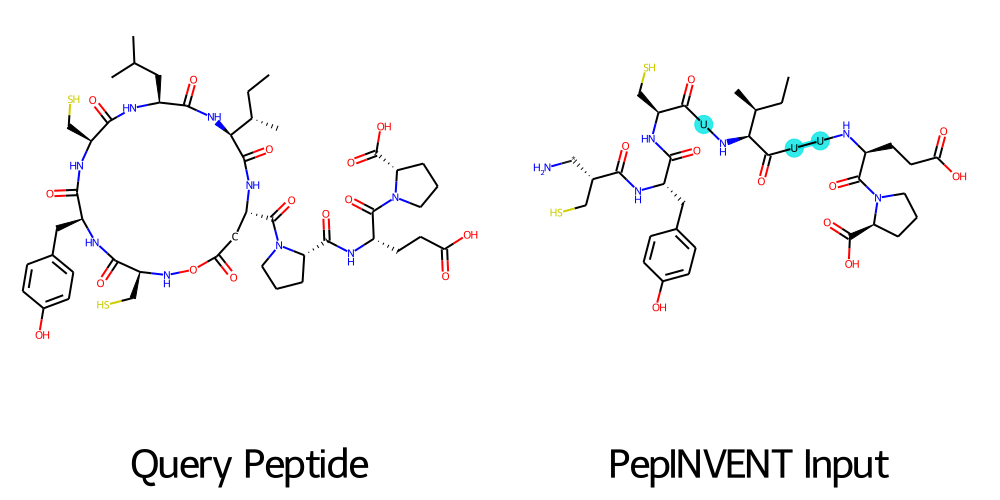

In [11]:
peptide_sequence = ['C', 'Y', 'C', 'L', 'I', 'D', 'P', 'E', 'P']
peptide_topology = 'Head-To-Sidechain'
masking_positions = [3,5,6]
cyclization_info = [0, 5]

peptide_smiles = [amino_acids[amino_acids['Name']==seq]['Smiles'].values[0] for seq in peptide_sequence]

query_peptide, pepinvent_input = build_peptide(peptide_smiles, peptide_topology, masking_positions, cyclization_info)
prepare_visualization(query_peptide, pepinvent_input, peptide_topology)

Query Peptide:
N[C@@H](Cn1c(S3)nnc1c1ccc(F)cc1)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CS)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]([C@H](CC)C)C(=O)N[C@@H](c1c(C)nc2nc(S3)nn2c1C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N1[C@@H](CCC1)C(=O)O


PepINVENT Input:
N[C@@H](Cn1c(S3)nnc1c1ccc(F)cc1)C(=O)|?|N[C@@H](CS)C(=O)|?|N[C@@H]([C@H](CC)C)C(=O)|N[C@@H](c1c(C)nc2nc(S3)nn2c1C)C(=O)|N1[C@@H](CCC1)C(=O)|N[C@@H](CCC(=O)O)C(=O)|?


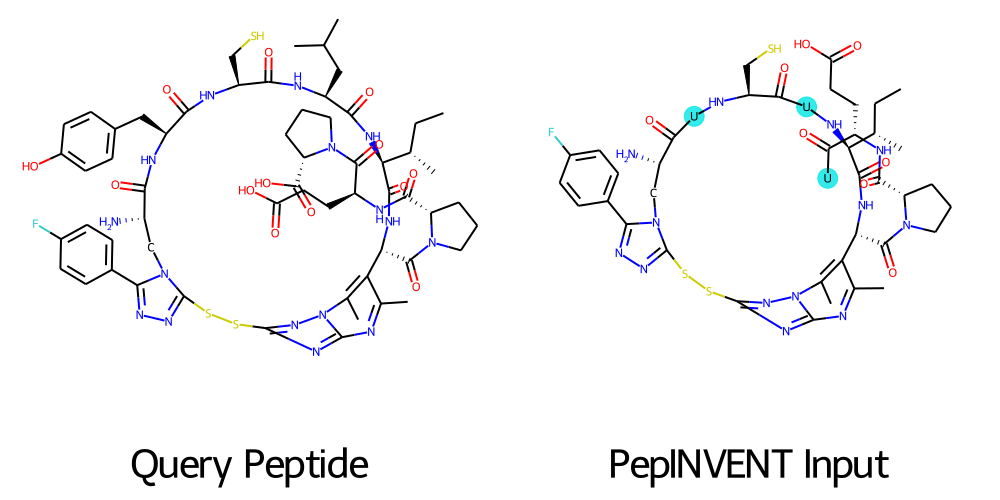

In [12]:
peptide_sequence = ['ZN9', 'Y', 'C', 'L', 'I', 'M6E', 'P', 'E', 'P']
peptide_topology = 'Disulfide-Bridge'
cyclization_info = [0,5]
masking_positions = [1,3,8]

peptide_smiles = [amino_acids[amino_acids['Name']==seq]['Smiles'].values[0] for seq in peptide_sequence]

query_peptide, pepinvent_input = build_peptide(peptide_smiles, peptide_topology, masking_positions, cyclization_info)
prepare_visualization(query_peptide, pepinvent_input, peptide_topology)